# Проект: Линейные модели в машинном обучении

# Введение

В рамках полученного задания нам предстоит провести классификацию уровня финансовой активности наших постоянных клиентов из интернет-магазина “В один клик”, собрать информацию о клиентах и разделить их на группы, разработать модель для определения вероятности снижения их покупательской активности в последующие три месяца, разделить покупателей на сегменты и предложить для них уникальные предложения. Для исследования у нас есть четыре файла с данными.

Файл `market_file.csv` содержит следующие данные: `id` — номер покупателя в корпоративной базе данных.
`Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень». `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт». `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель. `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента. `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце. `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте. `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев. `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
`Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца. `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
`Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта. `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Файл `market_money.csv` содержит следующие данные: `id` — номер покупателя в корпоративной базе данных. `Период` — название периода, во время которого зафиксирована выручка. `Выручка` — сумма выручки за период.

Файл `market_time.csv` содержит следующие данные: `id` — номер покупателя в корпоративной базе данных. `Период` — название периода, во время которого зафиксировано общее время. `минут` — значение времени, проведённого на сайте, в минутах.

Файл `money.csv` содержит следующие данные:`id` — номер покупателя в корпоративной базе данных. `Прибыль` — значение прибыли.

В ходе проекта мы загрузим имеющиеся данные, проведем первичный анализ и предварительную обработку, а также изучим каждый параметр этих данных. При необходимости мы осуществим заполнение пропущенных значений, удалим дубликаты, приведем данные к нужным типам, опишем или удалим аномалии и выбросы, осуществим переименование колонок и объединение файлов `market_file.csv`, `market_money.csv` и `market_time.csv`. Кроме того, мы проведем корреляционный анализ признаков.

Затем мы создадим пайплайн(конвейер) для выбора лучшей модели. Исходя из результатов работы этой модели и информации из таблицы `money.csv`, мы осуществим сегментацию покупателей и предоставим рекомендации для повышения покупательской активности.

# Загрузка данных

Прежде чем рабодать с данными, импортируем необходимые инструменты.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             precision_recall_curve)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   MinMaxScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

try:
    import phik
except ModuleNotFoundError:
    !pip install phik -q
    import phik

try:
    import shap
except ModuleNotFoundError:
    !pip install shap -q
    import shap

try:
    from imblearn.over_sampling import SMOTENC
except ModuleNotFoundError:
    !pip install imbalanced-learn -q
    
pd.set_option('float_format', '{:,.3f}'.format)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

<div class="alert alert-info"> <b>Комментарий студента:</b>
    
Классный способ, подйет в копилку к `pd.options.mode.chained_assignment = None` 

Выполнив необходиме импорты, загрузим данные и ознакомимся с ними.

In [2]:
mfile = pd.read_csv('/datasets/market_file.csv',sep=',', decimal='.')
mmoney= pd.read_csv('/datasets/market_money.csv',sep=',', decimal='.')
mtime= pd.read_csv('/datasets/market_time.csv',sep=',', decimal='.')
money = pd.read_csv('/datasets/money.csv',sep=';', decimal=',')

In [3]:
mfile.info()
display(mfile.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.400,5,121,0.000,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.100,3,1064,0.940,Товары для детей,3,2,3,2


<div class="alert alert-info"> <b>Комментарий студента:</b>
    
Интерессные рассуждения. Потому что зачастую в болиших задачах проблема не с реализацией мысли/идеи, а в том, чтобы понять "а что сделать-то с этим".

Типы данных в колонках соответствуют содержащейся в них информации. Однако в данных присутствуют опечатки. Пропусков в данных не обнаружено. Также часть данных выражена в бинормом формате.

In [4]:
mmoney.info()
display(mmoney.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.000
1,215348,текущий_месяц,"3,293.100"
2,215348,предыдущий_месяц,0.000
3,215349,препредыдущий_месяц,"4,472.000"
4,215349,текущий_месяц,"4,971.600"


Аналогично, типы данных в столбцах соответствуют сохраненной в них информации, пропусков в данных нет.

In [5]:
mtime.info()
display(mtime.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Типы данных в столбцах также соответствуют сохраненной в них информации, есть опечатка и в первом случае, пропусков в данных нет.

In [6]:
money.info()
display(money.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.980
1,215349,4.160
2,215350,3.130
3,215351,4.870
4,215352,4.210


Типы данных в столбцах соответствуют сохраненной в них информации, пропусков в данных нет.

Все данные успешно загружены, по типу данных и по пропускам файлы достаточно чистые, хотя встречаются опечатки. Сразу можно выделить столбец по которму можно объединять таблицы.

# Предобработка данных

Переименнуем столбцы в таблицах для удоства взаимодейсвтия с данными.

In [7]:
mfile = mfile.rename(columns =
    {'Покупательская активность' : 'same_level_activity',
     'Тип сервиса' : 'is_premium', 'Разрешить сообщать' :
     'allow_marketing', 'Маркет_актив_6_мес' : 'marketing_6_months',
     'Маркет_актив_тек_мес' : 'marketing_this_month', 'Длительность' :
     'days_since_registration', 'Акционные_покупки' : 'deal_share',
     'Популярная_категория' : 'popular_category',
     'Средний_просмотр_категорий_за_визит' :
      'average_category_per_visit',
     'Неоплаченные_продукты_штук_квартал' : 'unpaid_goods_quarter',
     'Ошибка_сервиса' : 'errors',
     'Страниц_за_визит' : 'pages_per_visit'}
)

mmoney = mmoney.rename(columns =
    {'Период' : 'time_period', 'Выручка' : 'earnings_per_period'}
)

mtime = mtime.rename(columns =
    {'Период' : 'is_current_period', 'минут' : 'minutes'}
)

money = money.rename(columns =
    {'Прибыль' : 'earnings_per_quarter'}
)

<div class="alert alert-info"> <b>Комментарий студента:</b>
    
    
Сильный инструмент. Эффективно убирает шороховатости. Однозначно разберусь и попробую его в одном из будущих проектов.

И у меня еще пунктик (помимо необхдимости в корректном названии стобцов) - это язык, мне сложно и некомфортено. когда мы работаем на англисйком языке, инструменте собранными на том синтаксисе, а названия у нас на кирилице, глаз режет очень.

Нами были замечены бинарные данные, убедимся в этом.

In [8]:
print(mfile['same_level_activity'].unique())
print(mfile['is_premium'].unique())
print(mfile['allow_marketing'].unique())
print(mtime['is_current_period'].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['текущий_месяц' 'предыдцщий_месяц']


Всё так. Только опечатки мешают этой истине. Исправим их и приведем данные к булеву типу.

In [9]:
mfile[mfile.select_dtypes('object').columns] = (
    mfile[mfile.select_dtypes('object').columns]
    .apply(lambda x: x.str.lower())
    .replace({'прежний уровень' : True, 'премиум' : True, 'да' : True,
              'снизилась' : False, 'стандартт' : False, 'стандарт' : False,
              'нет' : False})
)

mtime[mtime.select_dtypes('object').columns] = (
    mtime[mtime.select_dtypes('object').columns]
    .replace({'текущий_месяц' : True, 'предыдцщий_месяц' : False})
)

Проверим все таблицы, наименования в них и типы данных.

In [10]:
mfile.info()
display(mmoney.info())
display(mtime.info())
display(money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          1300 non-null   int64  
 1   same_level_activity         1300 non-null   bool   
 2   is_premium                  1300 non-null   bool   
 3   allow_marketing             1300 non-null   bool   
 4   marketing_6_months          1300 non-null   float64
 5   marketing_this_month        1300 non-null   int64  
 6   days_since_registration     1300 non-null   int64  
 7   deal_share                  1300 non-null   float64
 8   popular_category            1300 non-null   object 
 9   average_category_per_visit  1300 non-null   int64  
 10  unpaid_goods_quarter        1300 non-null   int64  
 11  errors                      1300 non-null   int64  
 12  pages_per_visit             1300 non-null   int64  
dtypes: bool(3), float64(2), int64(7),

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 2600 non-null   int64
 1   is_current_period  2600 non-null   bool 
 2   minutes            2600 non-null   int64
dtypes: bool(1), int64(2)
memory usage: 43.3 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1300 non-null   int64  
 1   earnings_per_quarter  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

Проверим данные на предмет полных дубликатов.

In [11]:
display(mfile.duplicated().sum())
display(mmoney.duplicated().sum())
display(mtime.duplicated().sum())
display(money.duplicated().sum())

0

0

0

0

<div class="alert alert-info"> <b>Комментарий студента:</b>
    
Понимаю о чем ты. Данный шаг скорее в формате от общего к частному, на данном этапе задача была отсечь грубые и яркие недочеты в данных    

Отлично

Судя по даннным, уникальных `id` должно быть 1300, првоерим эту гипотезу.

In [12]:
display(mfile['id'].nunique())
display(mmoney['id'].nunique())
display(mtime['id'].nunique())
display(money['id'].nunique())


1300

1300

1300

1300

Так и оказалось.

Мы провели следующие манипуляции с данными: переименование столбцов во всех четырёх датафреймах, изменили тип данных в четырёх столбцах двух датафреймов на булев. Обнаружили, что в данных нет полных дубликатов и в каждом датафрейме содержатся данные ровно о 1 300 уникальных `id` пользователей. Предположим, что эти 1 300 `id` совпадают во всех датафреймах, поскольку в целом данные достаточно качесвтенные и чистые.

# Исследовательский анализ данных

Изучим данные более подробно. Для некоторых шагов поспользуемся фнукциями.

### Качественные показатели

In [13]:
def pie_chart(data, labels, title):
    (data.value_counts()
     .plot(figsize=(7, 7), 
           kind='pie', 
           autopct='%1.1f%%',
           colors = sns.color_palette('pastel')[0:5],
           fontsize=13,
           labels = labels
          ).set(title = title,
                ylabel = ''))
plt.show()

Посмотрим на столбец `same_level_activity` датафрейма `mfile`.

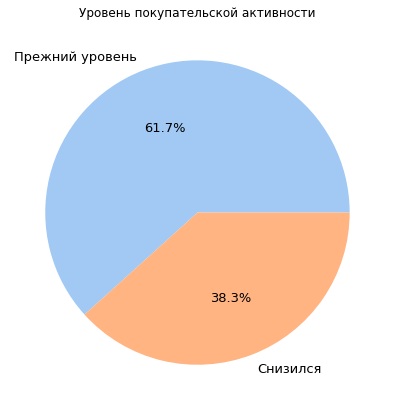

In [14]:
pie_chart(
    mfile['same_level_activity'],
    ['Прежний уровень', 'Снизился'],
    'Уровень покупательской активности'
)

<div class="alert alert-info"> <b>Комментарий студента:</b>
  
Безусловно. Дисбаланс на лицо примерно 1:2. Как раз поэтому далее я от него избавился и пришел к метрике Accuracy. Если работать далее с несбалансированными данными, то как ты верно подметил, roc-auc подошла бы.

У большинства клиентов, 61.7% от общего числа, уровень покупательской активности не изменился, однако у 38.3% клиентов этот уровень снизился.

Посмотрим на столбец `is_premium` датафрейма `mfile`.

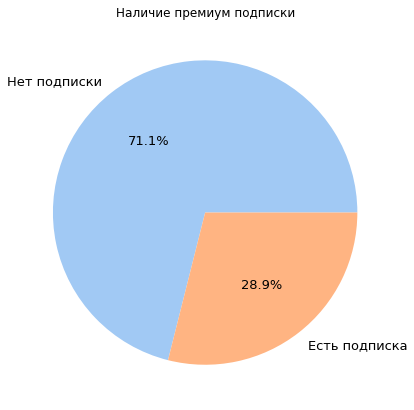

In [15]:
pie_chart(
    mfile['is_premium'],
    ['Нет подписки', 'Есть подписка'], 
    'Наличие премиум подписки'
)

Большинство клиентов, 71.1% от общего числа, не имеют премиум-подписки. Только 28.9% клиентов ей пользуются.

Посмотрим на столбец `allow_marketing` датафрейма `mfile`.

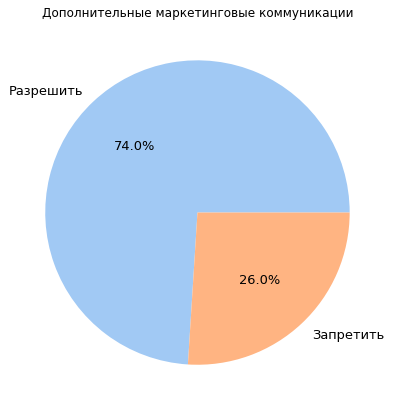

In [16]:
pie_chart(
    mfile['allow_marketing'],
    ['Разрешить', 'Запретить'], 
    'Дополнительные маркетинговые коммуникации'
)

Большинство клиентов, 74% от общего числа, предпочитают получать дополнительные маркетинговые сообщения о товарах, которые их интересуют. 26% клиентов в нашей выборке отказались от этой опции.

Посмотрим на столбец `is_current_period` датафрейма `mtime`.

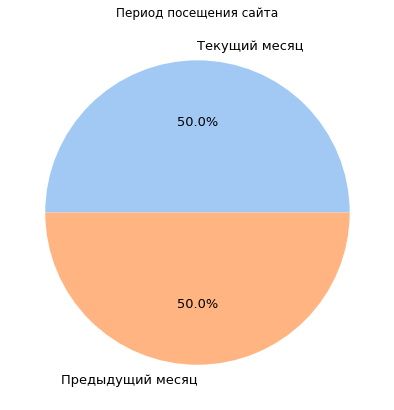

In [17]:
pie_chart(
    mtime['is_current_period'], 
    ['Текущий месяц', 'Предыдущий месяц'],
    'Период посещения сайта'
)

Отлично, данные в динамике даны в равных пропорциях.

Посмотрим на столбец `popular_category` датафрейма `mfile`.

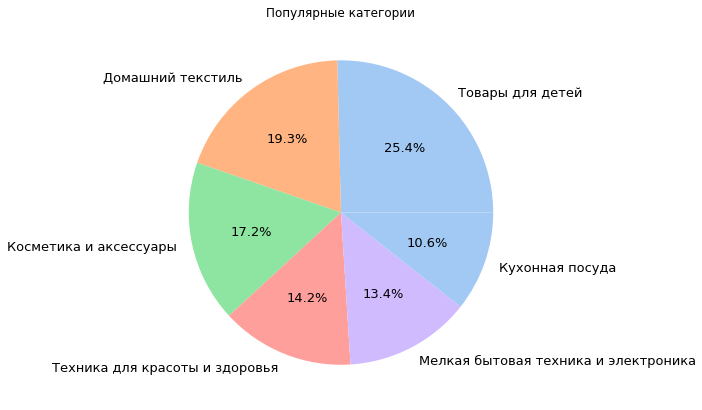

In [18]:
pie_chart(
    mfile['popular_category'],
    ['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
    'Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника',
    'Кухонная посуда'],
    'Популярные категории'
)

<div class="alert alert-info"> <b>Комментарий студента:</b>
 
Очень жду добротной литературы по визулизации. Ранее только через matplotlib визуализровал, сейчас стал активнее подключать seaborn. Кто-то коллег, вроде, ploty сипользвует. Потому что графики не всегда удобно собираются и не всегда выглядя насктолько симпатично, как хотелось бы.

Самые популярные категории товаров среди посетителей сайта - это Товары для детей (25.4%), Домашний текстиль (19.3%) и Косметика и аксессуары (17.2%). Далее идут менее выраженные категории. В целом, список категорий указывает на то, что основной аудиторией сайта являются семьи с детьми, где женщины играют главную роль в принятии решений о покупках.

Посмотрим на столбец `time_period` датафрейма `mmoney`.


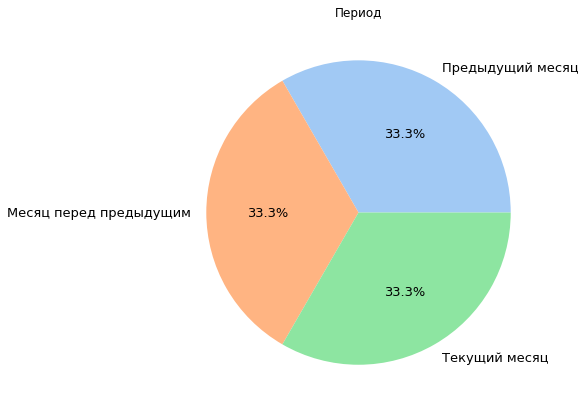

In [19]:
pie_chart(
    mmoney['time_period'], 
    ['Предыдущий месяц', 'Месяц перед предыдущим', 'Текущий месяц'],
    'Период'
)

Как и в сулчае с посещением сайта, данные распределены равномерно по всем трем периодам.

Теперь рассмотрим столбцы с количественными данными. Также воспользовавшись функцией.

### Количественные показатели

Пора перейти к количесвтенным показтелям. К ним больше подойдут гистограммы для визулизации и последующего анализа.

Как в случае с даиграммами прибегнем к фунции для большей читаемости.

In [20]:
def num_vis(data, title, xlabel, ylabel):
    plt.figure(figsize=(17, 5))
    sns.set_theme(palette="pastel")
    sns.histplot(
        data,
        bins = 20
    ).set(
        title = title,
        xlabel = xlabel,
        ylabel = ylabel)
    plt.show()

    plt.figure(figsize=(17, 3))
    sns.boxplot(
        data, 
        orient='h'
    ).set(
        title = title,
        xlabel = xlabel,
        )
    plt.show()
    
    display(data.describe())

Начнем со столбца `marketing_6_months`.

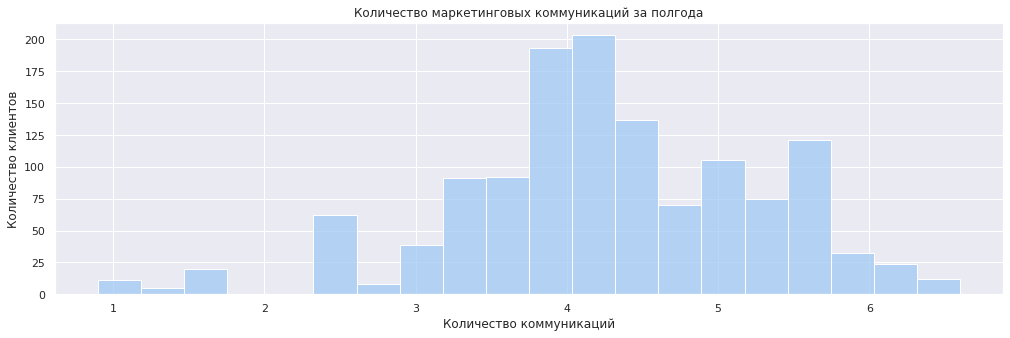

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


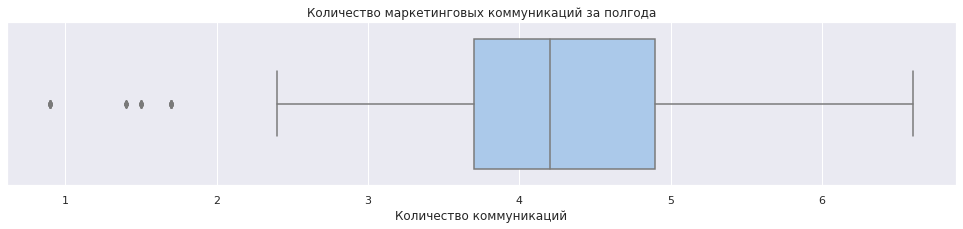

count   1,300.000
mean        4.254
std         1.015
min         0.900
25%         3.700
50%         4.200
75%         4.900
max         6.600
Name: marketing_6_months, dtype: float64

In [21]:
num_vis(
    mfile['marketing_6_months'], 
    'Количество маркетинговых коммуникаций за полгода',
    'Количество коммуникаций',
    'Количество клиентов'
)

<div class="alert alert-info"> <b>Комментарий студента:</b>
    
Как раз в этом проекте убрал подписи осей на данных таблицах (в прошлом, например, они были), чтобы разгрузить и фунцию и ее вызов, ведь в этих графиках данные из категории "ну понятно/видно же" где что. Это же хотел сделать и с круговыми диаграммами, только там данные не столь прозрачны при визуализации. Но я тебя услышал. Добавил.

Клиенты интернет-магазина получали в среднем 4,254 маркетинговые рассылки в месяц. Медианное значение равно 4,2. Разброс значений велик: от 0,9 до 6,6.

Рассмотрим столбец `marketing_this_month`.

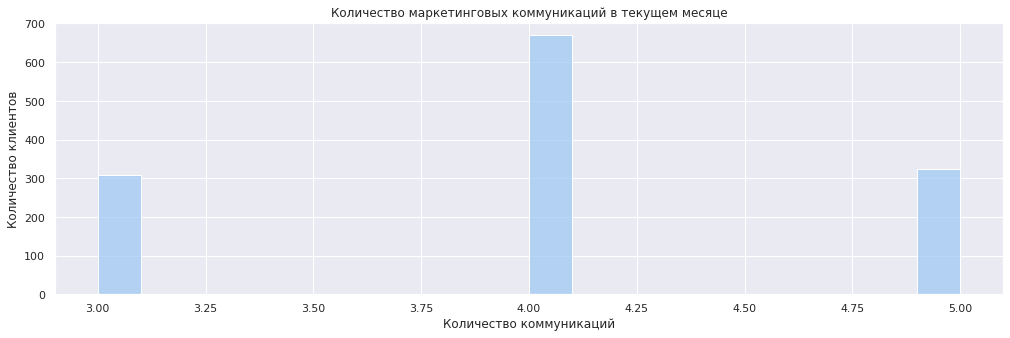

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


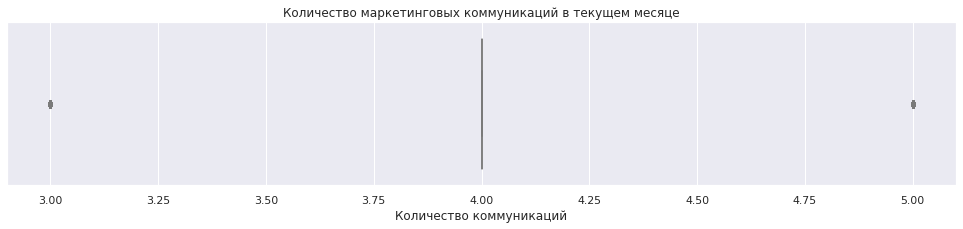

count   1,300.000
mean        4.012
std         0.697
min         3.000
25%         4.000
50%         4.000
75%         4.000
max         5.000
Name: marketing_this_month, dtype: float64

In [22]:
num_vis(
    mfile['marketing_this_month'], 
    'Количество маркетинговых коммуникаций в текущем месяце',
    'Количество коммуникаций',
    'Количество клиентов'
)

В этом столбце данные могут принимать одно из трёх значений: 3, 4 или 5. Медиана значений равна 4.

Теперь посмотрим на столбец `days_since_registration`.

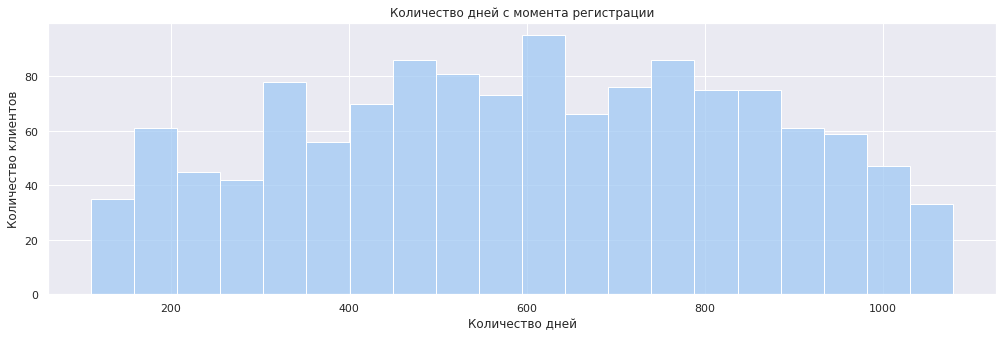

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


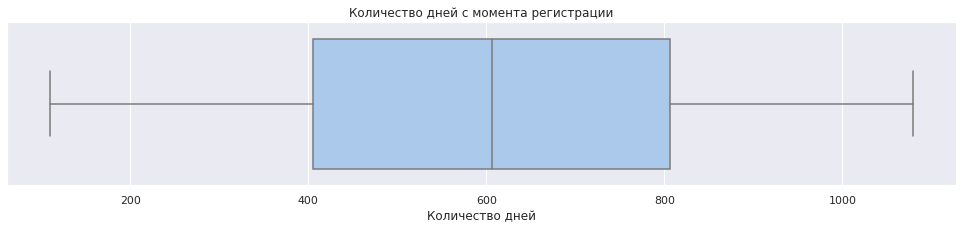

count   1,300.000
mean      601.898
std       249.856
min       110.000
25%       405.500
50%       606.000
75%       806.000
max     1,079.000
Name: days_since_registration, dtype: float64

In [23]:
num_vis(
    mfile['days_since_registration'], 
    'Количество дней с момента регистрации',
    'Количество дней',
    'Количество клиентов'
)

Все пользователи в выборке зарегистрированы на сайте не менее 110 дней. Некоторые из них зарегистрировались почти 3 года назад. Средний «стаж» на сайте составляет около 2 лет (601,898 дней). Медиана чуть больше - 606 дней.

Теперь посмотрим на столбец `deal_share`.

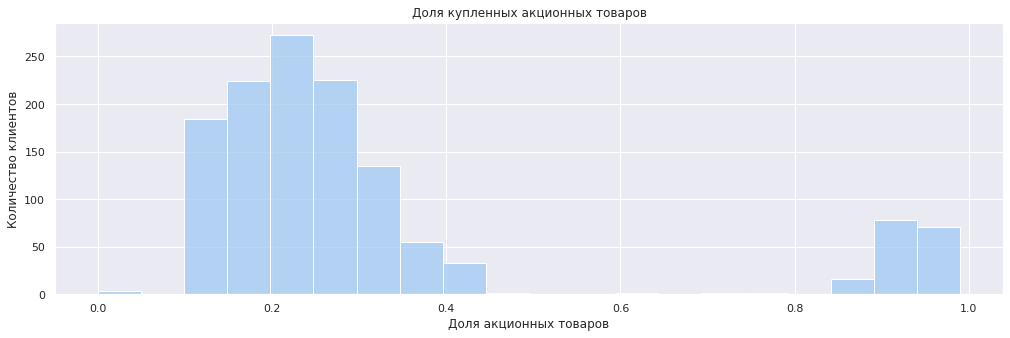

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


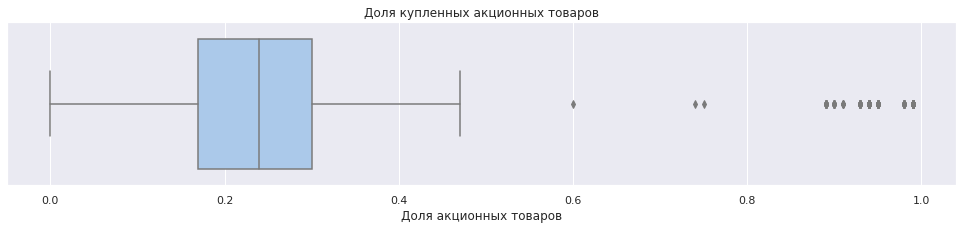

count   1,300.000
mean        0.320
std         0.250
min         0.000
25%         0.170
50%         0.240
75%         0.300
max         0.990
Name: deal_share, dtype: float64

In [24]:
num_vis(
    mfile['deal_share'], 
    'Доля купленных акционных товаров',
    'Доля акционных товаров',
    'Количество клиентов'
)

Пользователи сайта в среднем покупают 32% товаров со скидкой (медиана ниже, 24%). Некоторые пользователи, по-видимому, покупают товары вне зависимости от того, участвует ли товар в акции или нет (минимальная доля акционных товаров равна 0%). Однако есть и такие, кто покупает 99% товаров по акции. Пользователей, которые приобретают 60% товаров и более со скидкой, все же немного (выбросы в правой части “ящика с усами”).

Теперь посмотрим на столбец `average_category_per_visit`.

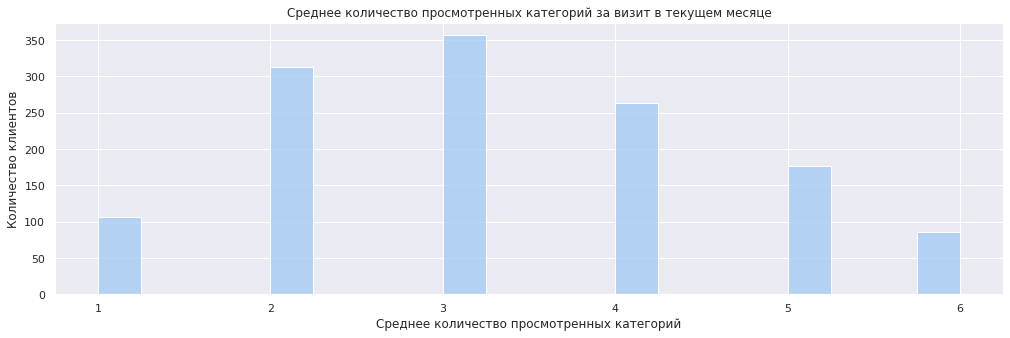

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


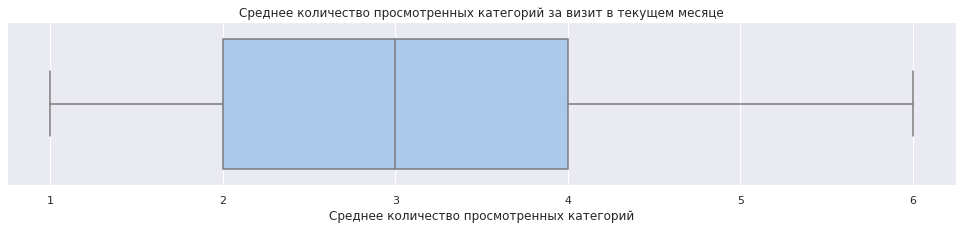

count   1,300.000
mean        3.270
std         1.355
min         1.000
25%         2.000
50%         3.000
75%         4.000
max         6.000
Name: average_category_per_visit, dtype: float64

In [25]:
num_vis(
    mfile['average_category_per_visit'], 
    'Среднее количество просмотренных категорий за визит в текущем месяце',
    'Среднее количество просмотренных категорий',
    'Количество клиентов'
)

В нашей выборке всего 6 категорий товаров (вероятно, это все доступные категории на сайте), поэтому значение ограничено числами от 1 до 6. В среднем посетитель сайта просматривал 3,27 категории за один визит медиана равна 3 категориям.

Теперь посмотрим на столбец `unpaid_goods_quarter`.

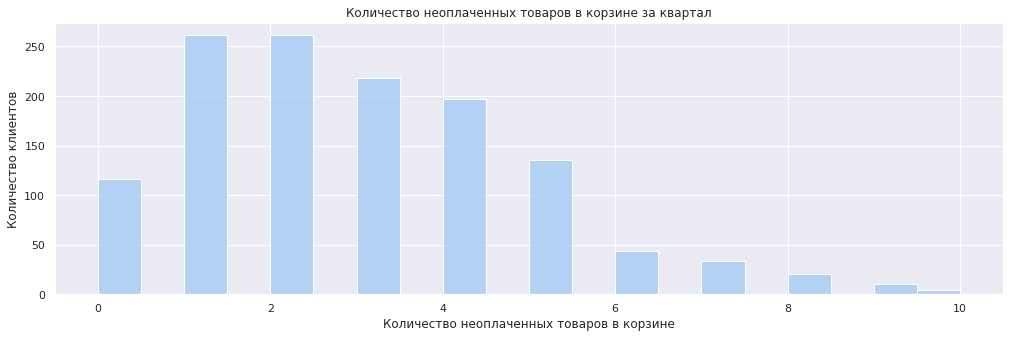

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


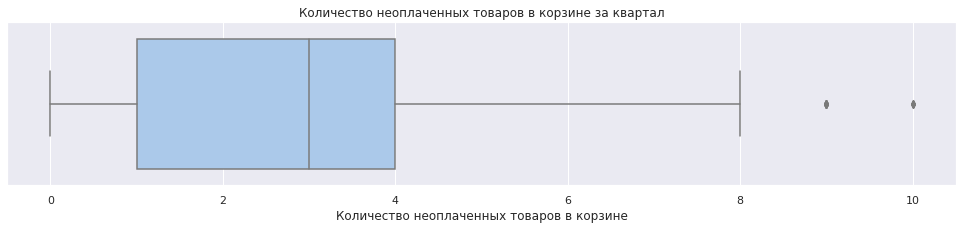

count   1,300.000
mean        2.840
std         1.971
min         0.000
25%         1.000
50%         3.000
75%         4.000
max        10.000
Name: unpaid_goods_quarter, dtype: float64

In [26]:
num_vis(
    mfile['unpaid_goods_quarter'], 
    'Количество неоплаченных товаров в корзине за квартал',
    'Количество неоплаченных товаров в корзине',
    'Количество клиентов'
)

В среднем у клиентов за три месяца накапливается 2,84 непогашенных товара (медиана - 3 товара). Некоторые клиенты не имеют непогашенных товаров, а другие имеют 9 или 10 непогашенных товаров. Возможно, покупатели просто сохраняют товары в своей корзине и следят за изменением цен, чтобы совершить покупку, когда предложение станет более выгодным, чем обычно.

Теперь посмотрим на столбец `errors`.

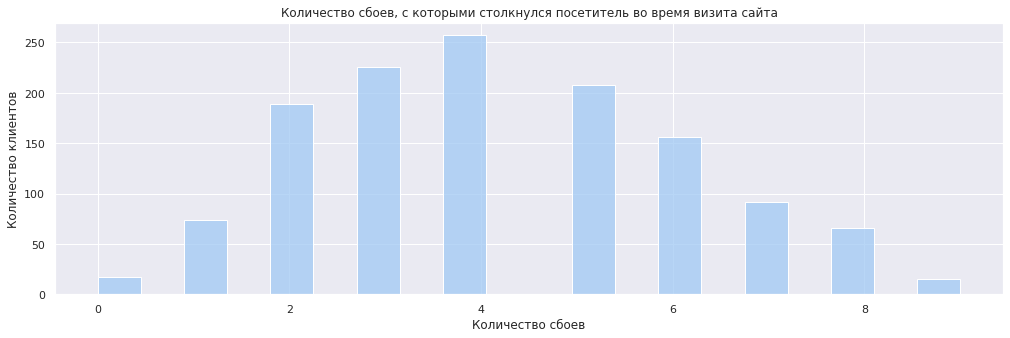

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


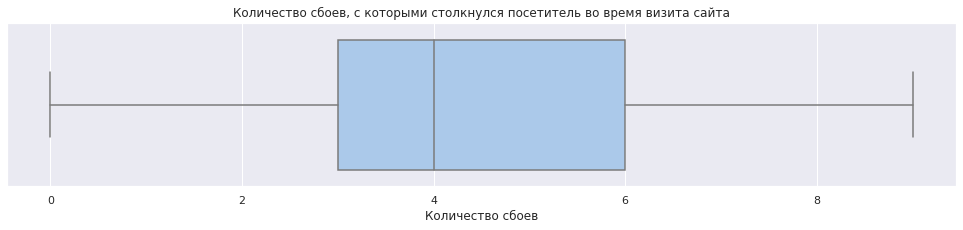

count   1,300.000
mean        4.185
std         1.955
min         0.000
25%         3.000
50%         4.000
75%         6.000
max         9.000
Name: errors, dtype: float64

In [27]:
num_vis(
    mfile['errors'], 
    'Количество сбоев, с которыми столкнулся посетитель во время визита сайта',
    'Количество сбоев',
    'Количество клиентов'
)

Вероятно, число ошибок в этом столбце отражает общее количество ошибок за весь период использования сайта, поскольку в среднем пользователи столкнулись с ошибкой 4,185 раза (медиана числа ошибок - 4). Количество ошибок за один визит было бы слишком большим. Некоторые пользователи не столкнулись ни с одной ошибкой. Были и такие, которые сталкивались с 9 ошибками.

Теперь посмотрим на столбец `pages_per_visit`.

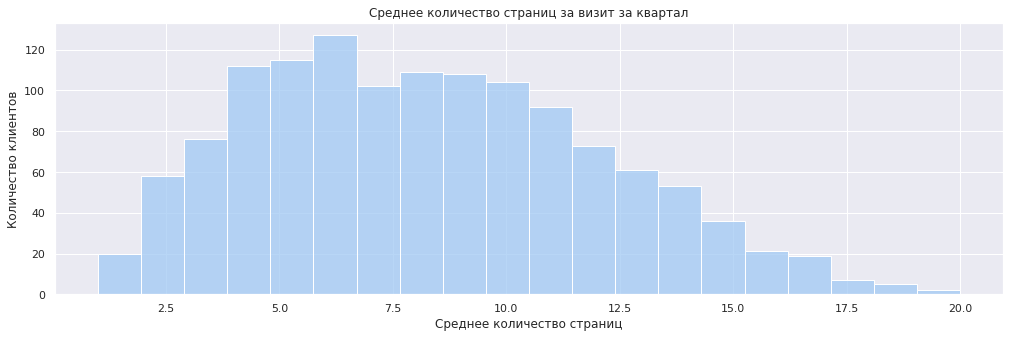

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


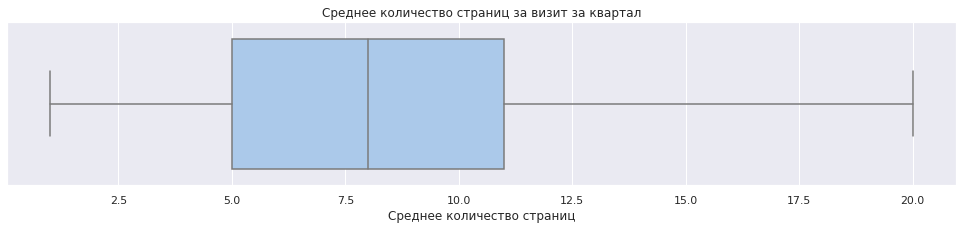

count   1,300.000
mean        8.177
std         3.978
min         1.000
25%         5.000
50%         8.000
75%        11.000
max        20.000
Name: pages_per_visit, dtype: float64

In [28]:
num_vis(
    mfile['pages_per_visit'], 
    'Среднее количество страниц за визит за квартал',
    'Среднее количество страниц',
    'Количество клиентов'
)

В среднем пользователи просматривали 8,177 страниц за один визит (медиана просмотров - 8 страниц). Некоторые пользователи просматривали только одну страницу, в то время как другие просматривали до 20 страниц за один визит.

Теперь посмотрим на столбец `earnings_per_quarter` датафрейма `money`.

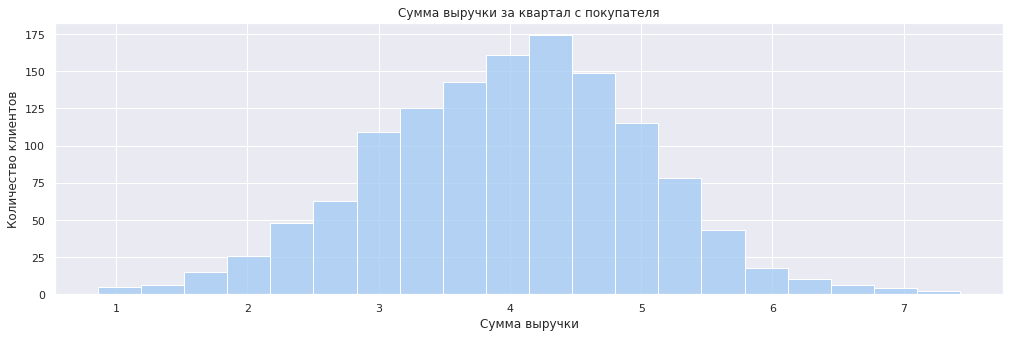

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


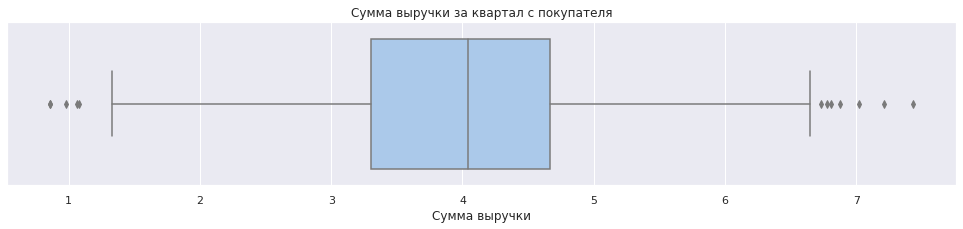

count   1,300.000
mean        3.997
std         1.014
min         0.860
25%         3.300
50%         4.045
75%         4.670
max         7.430
Name: earnings_per_quarter, dtype: float64

In [29]:
num_vis(
    money['earnings_per_quarter'], 
    'Сумма выручки за квартал с покупателя',
    'Сумма выручки',
    'Количество клиентов'
)

Нам неизвестна точная сумма дохода, но можно предположить, что он указан в тысячах рублей. В среднем доход покупателей составил 3997₽ за квартал (медиана 4045₽). Некоторые покупатели принесли около 1000₽ (минимум 860₽), но были и “супер-покупатели”, которые принесли доход более 7000₽ за квартал.

Теперь посмотрим на столбец `earnings_per_period` датафрейма `mmoney`.

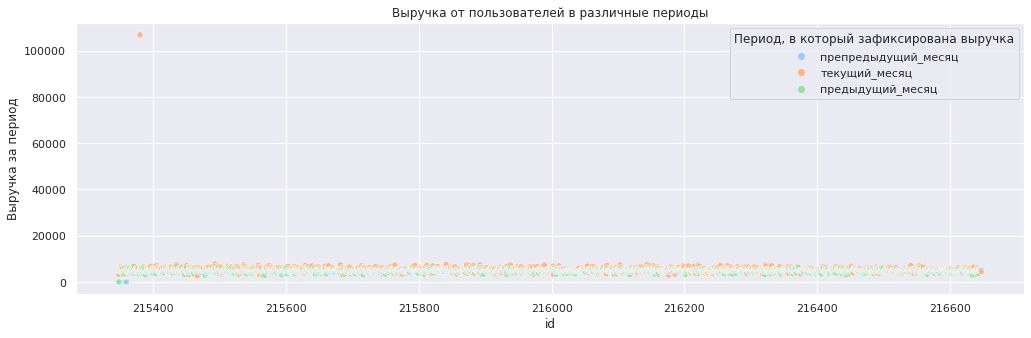

count     1,300.000
mean      5,314.961
std       2,939.708
min       2,758.700
25%       4,706.050
50%       5,179.950
75%       5,761.725
max     106,862.200
Name: earnings_per_period, dtype: float64

count   1,300.000
mean    4,936.920
std       739.598
min         0.000
25%     4,496.750
50%     5,005.000
75%     5,405.625
max     6,869.500
Name: earnings_per_period, dtype: float64

count   1,300.000
mean    4,825.207
std       405.980
min         0.000
25%     4,583.000
50%     4,809.000
75%     5,053.500
max     5,663.000
Name: earnings_per_period, dtype: float64

In [30]:
plt.figure(figsize=(17, 5))
sns.scatterplot(
    data=mmoney, 
    x="id", 
    y="earnings_per_period", 
    hue="time_period"
)
plt.legend(
    loc='upper right', 
    title='Период, в который зафиксирована выручка'
)
plt.ylabel('Выручка за период')
plt.title('Выручка от пользователей в различные периоды')
plt.show()


display(
    mmoney['earnings_per_period']
    [mmoney['time_period'] == 'текущий_месяц']
    .describe()
)
display(
    mmoney['earnings_per_period']
    [mmoney['time_period'] == 'предыдущий_месяц']
    .describe()
)
(mmoney['earnings_per_period']
 [mmoney['time_period'] == 'препредыдущий_месяц']
 .describe()
)

Мы обнаружили одно очень большое значение дохода в текущем месяце (более 106 тысяч рублей). В шести случаях мы видим нулевой доход в предыдущем или предпредыдущем месяце.

Наибольшее значение дохода без аномального значения - 7799,4 рублей, наименьшее (без нулевых) - 2758,7 рублей. Медиана дохода - около 5 тысяч рублей. Мы не учитываем среднее значение, так как оно искажено из-за аномальных данных или понижено из-за нулевых значений дохода.

Согласно условиям задачи, мы должны выбрать клиентов, которые совершили покупки в течение квартала. То есть, мы можем исключить случаи с нулевым доходом и клиента с аномально высоким доходом. Нам известны идентификаторы строк (0, 2, 28, 29, 34, 35, и 98). Выясним номера клиентов в базе данных клиентов и удалим эти данные из всех четырёх фреймов данных.

In [31]:
display(list(mmoney.iloc[i][0] for i in [0, 2, 28, 29, 34, 35]))
display(mmoney.iloc[98][0])

[215348, 215348, 215357, 215357, 215359, 215359]

215380

Оказалось, что только трое из наших клиентов не совершали покупок ни в предыдущем, ни в предпредыдущем месяцах. Таким образом, мы можем исключить из рассмотрения всего четыре строки из 1300 (около 0,03% данных), восемь из 2600 (приблизительно 0,03% данных) и двенадцать из 3900, примерно 0,03% данных.

Перед удаление данных посмотрим на столбец `minutes` датафрейма `df_mtime`.

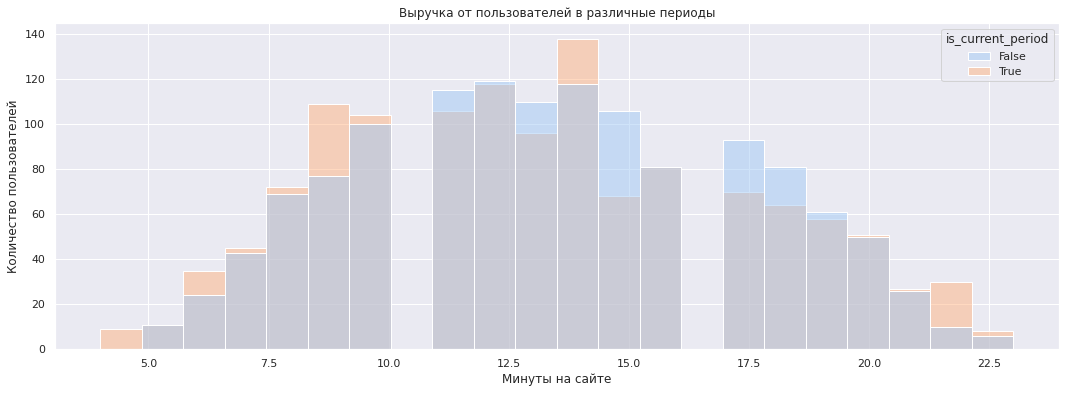

count   1,300.000
mean       13.205
std         4.221
min         4.000
25%        10.000
50%        13.000
75%        16.000
max        23.000
Name: minutes, dtype: float64

count   1,300.000
mean       13.468
std         3.932
min         5.000
25%        11.000
50%        13.000
75%        17.000
max        23.000
Name: minutes, dtype: float64

In [32]:
plt.figure(figsize=(18, 6))
sns.histplot(
    data=mtime, 
    x='minutes',
    hue="is_current_period"
)
plt.xlabel('Минуты на сайте')
plt.ylabel('Количество пользователей')
plt.title('Выручка от пользователей в различные периоды')
plt.show()

display(
    mtime['minutes']
    [mtime['is_current_period'] == True]
    .describe()
)
(mtime['minutes']
 [mtime['is_current_period'] == False]
 .describe()
)

Аномальных значений в данном столбце не обнаружено.За месяц минимальное время пребывания на сайте уменьшилось на одну минуту, а среднее время сократилось с 13,468 минут (~ 13 минут 28 секунд) до 13,205 минут (~ 13 минут 12 секунд). Медианное и максимальное значения времени пребывания на сайте не изменились (13 минут и 23 минуты, соответственно).

Теперь мы можем удалить выявленные ранее аномальные данные.

In [33]:
mfile = mfile[(
    (mfile.id != 215348) &
    (mfile.id != 215357) &
    (mfile.id != 215359) &
    (mfile.id != 215380)
)]


mmoney = mmoney[(
    (mmoney.id != 215348) &
    (mmoney.id != 215357) &
    (mmoney.id != 215359) &
    (mmoney.id != 215380)
)]


mtime = mtime[(
    (mtime.id != 215348) &
    (mtime.id != 215357) &
    (mtime.id != 215359) &
    (mtime.id != 215380)
)]

money = money[(
    (money.id != 215348) &
    (money.id != 215357) &
    (money.id != 215359) &
    (money.id != 215380)
)]

Мы проанализировали данные во всех столбцах четырех датафреймов. Провели статистический анализ данных. Исключили одну аномалию и три строки о клиентах, не совершавших покупки два месяца. Получил ипортреть типичного клиента интернет-магазина “В один клик”, который сохранил прежний уровень покупательской активности. У него нет премиальной подписки. Он согласился на получение дополнительных маркетинговых сообщений по интересующим товарам. Приобрел товары в категориях “Товары для детей”, “Домашний текстиль” или “Косметика и аксессуары”. В среднем получил чуть более 4 маркетинговых сообщений от интернет-магазина (4 сообщения в текущем месяце). Зарегистрировался на сайте около 600 дней назад. Примерно 24% товаров приобрел по акциям. В текущем месяце просматривал 3 категории товаров за визит. Имеет около 3 непогашенных товаров в корзине за квартал. Столкнулся примерно с 4 ошибками во время посещения сайта. Просмотрел около 8 страниц товаров за квартал. Принес магазину доход около 4 тысяч рублей. Провел на сайте в среднем 13 с половиной минут.

# Объединение таблиц

Объединим данные из трех датасетов `mfile`, `mmoney`, `mtime` в единый датасет. Важный момент: количество строк в датасете df_mfile в три раза меньше, чем df_mmoney, и в два раза меньше, чем в датасете df_mtime. Это связано с тем, что в одном столбце собраны данные за разные временные промежутки. Чтобы уравнять количество строк, мы можем разбить датасеты на периоды и объединить их по id. Начнем с обработки датасета `mmoney`.

In [34]:
#Разделим mmoney на три датафрейма.
mmoney_current = (
    mmoney[mmoney.time_period == 'текущий_месяц']
)

mmoney_last = (
    mmoney[mmoney.time_period == 'предыдущий_месяц']
)

mmoney_before_last = (
    mmoney[mmoney.time_period == 'препредыдущий_месяц']
)

#Удалим ненужный столбец и переименовываем нужный.
mmoney_current = mmoney_current.drop(
    'time_period',
    axis = 1
).rename(
    columns = {'earnings_per_period' : 'earnings_this_month'}
)

mmoney_last = mmoney_last.drop(
    'time_period',
    axis = 1
).rename(
    columns = {'earnings_per_period' : 'earnings_last_month'}
)

mmoney_before_last = mmoney_before_last.drop(
    'time_period',
    axis = 1
).rename(
    columns = {'earnings_per_period' : 'earnings_before_last'}
)

#Объединим три датафрейма обратно.
mmoney = mmoney_current.merge(
    mmoney_last.merge(
        mmoney_before_last,
        on = 'id'
    ),
    on = 'id'
)

#Выведем информацию о датафрейме, чтобы проверить результат.
mmoney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1296 non-null   int64  
 1   earnings_this_month   1296 non-null   float64
 2   earnings_last_month   1296 non-null   float64
 3   earnings_before_last  1296 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 50.6 KB


<div class="alert alert-info"> <b>Комментарий студента:</b>

😅

Заработался. Дейсвтитльно, сводной таблицей сильно проще.

Теперь выполним аналогичные действия с датафреймом `df_mtime`.

In [35]:
#Разделим mmoney на два датафрейма.
mtime_current = (
    mtime[mtime.is_current_period == True]
)

mtime_last = (
    mtime[mtime.is_current_period == False]
)

#Удалим ненужный столбец и переименовываем нужный.
mtime_current = mtime_current.drop(
    'is_current_period',
    axis = 1
).rename(
    columns = {'minutes' : 'minutes_this_month'}
)

mtime_last = mtime_last.drop(
    'is_current_period',
    axis = 1
).rename(
    columns = {'minutes' : 'minutes_last_month'}
)

#Объединим два датафрейма обратно.
mtime = mtime_current.merge(
    mtime_last,
    on = 'id'
)

#Выведем информацию о датафрейме, чтобы проверить результат.
mtime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   id                  1296 non-null   int64
 1   minutes_this_month  1296 non-null   int64
 2   minutes_last_month  1296 non-null   int64
dtypes: int64(3)
memory usage: 40.5 KB


Теперь можно выполнить объединение трех датафреймов в один.

In [36]:
df = mfile.merge(
    mmoney.merge(
        mtime,
        on = 'id'
    ),
    on = 'id'
)

#Выведем информацию о датафрейме, чтобы проверить результат.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          1296 non-null   int64  
 1   same_level_activity         1296 non-null   bool   
 2   is_premium                  1296 non-null   bool   
 3   allow_marketing             1296 non-null   bool   
 4   marketing_6_months          1296 non-null   float64
 5   marketing_this_month        1296 non-null   int64  
 6   days_since_registration     1296 non-null   int64  
 7   deal_share                  1296 non-null   float64
 8   popular_category            1296 non-null   object 
 9   average_category_per_visit  1296 non-null   int64  
 10  unpaid_goods_quarter        1296 non-null   int64  
 11  errors                      1296 non-null   int64  
 12  pages_per_visit             1296 non-null   int64  
 13  earnings_this_month         1296 

Успешно объединили три датафрейма в один.

# Корреляционный анализ

В финальном датафрейме содержится 18 столбцов с данными. Для целей проведения корреляционного анализа мы можем исключить из рассмотрения стобец `id`.

Построим три матрицы корреляции с использованием функционала библиотеки `phik`. Для общих данных и с разбивокай по классам целевого признака.

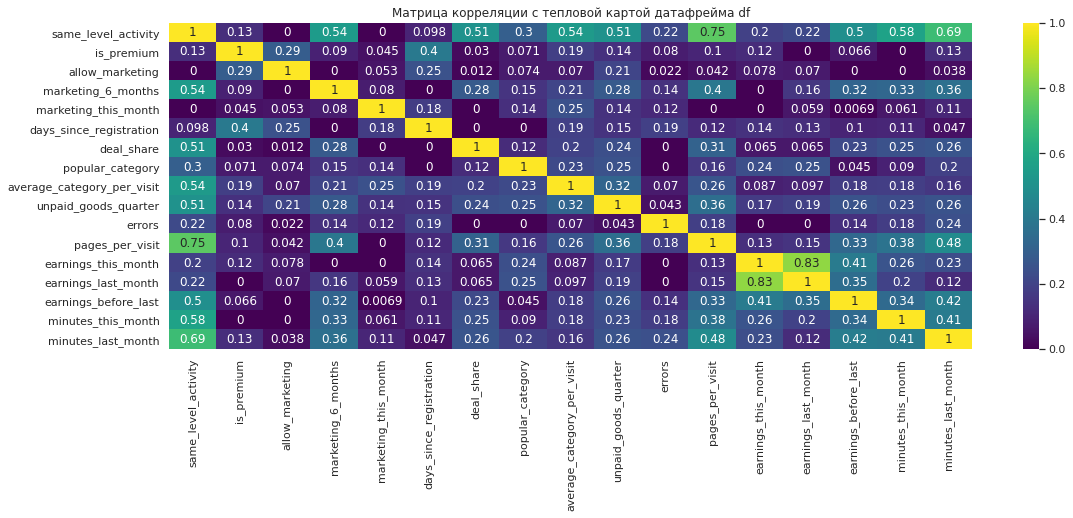

In [66]:
plt.figure(figsize = (18, 6))
sns.heatmap(
    df.drop(
        ['id'],
        axis = 1
    ).phik_matrix(
        interval_cols = (
            ['marketing_6_months', 'marketing_this_month',
             'days_since_registration', 'deal_share',
             'average_category_per_visit', 'unpaid_goods_quarter',
             'errors', 'pages_per_visit', 'earnings_this_month',
             'earnings_last_month', 'earnings_before_last',
             'minutes_this_month', 'minutes_last_month']
        )
    ),
    annot = True,
    cmap = 'viridis'
)
plt.title('Матрица корреляции с тепловой картой датафрейма df')
plt.show()

Not enough unique value for variable same_level_activity for analysis 1. Dropping this column


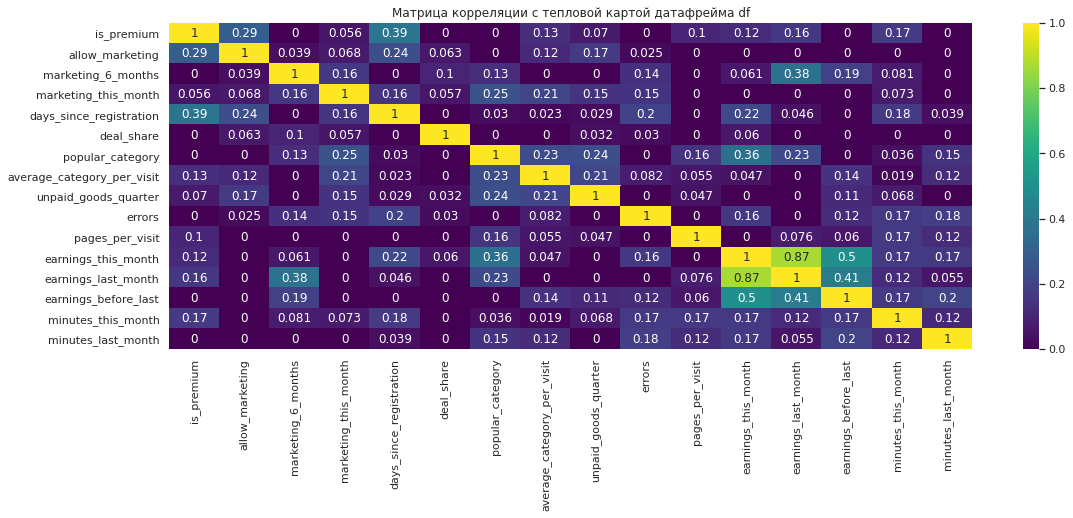

In [64]:
plt.figure(figsize = (18, 6))
sns.heatmap(
    df.query('same_level_activity == True')
    .drop(
        ['id'],
        axis = 1
    ).phik_matrix(
        interval_cols = (
            ['marketing_6_months', 'marketing_this_month',
             'days_since_registration', 'deal_share',
             'average_category_per_visit', 'unpaid_goods_quarter',
             'errors', 'pages_per_visit', 'earnings_this_month',
             'earnings_last_month', 'earnings_before_last',
             'minutes_this_month', 'minutes_last_month']
        )
    ),
    annot = True,
    cmap = 'viridis'
)
plt.title('Матрица корреляции с тепловой картой датафрейма df')
plt.show()

Not enough unique value for variable same_level_activity for analysis 1. Dropping this column


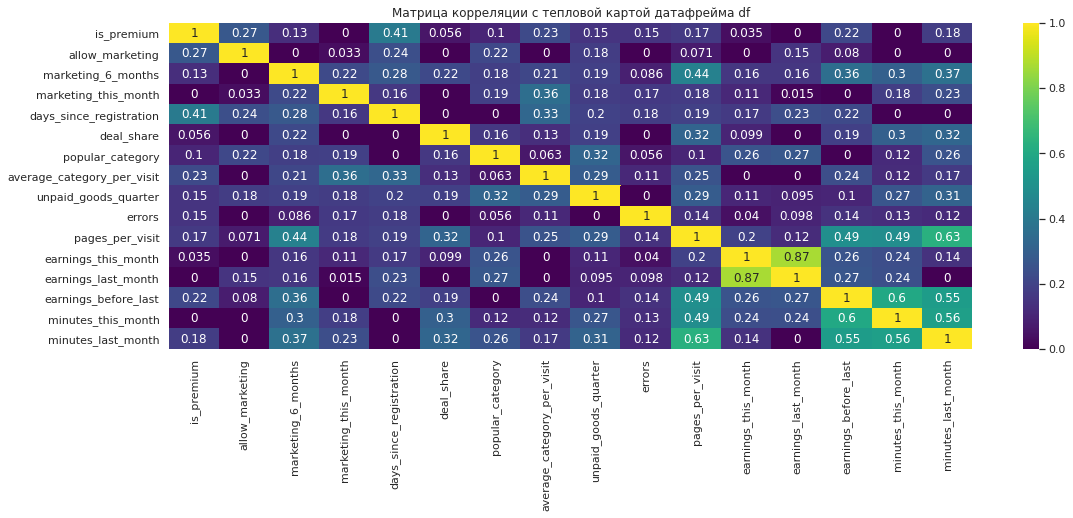

In [65]:
plt.figure(figsize = (18, 6))
sns.heatmap(
    df.query('same_level_activity == False')
    .drop(
        ['id'],
        axis = 1
    ).phik_matrix(
        interval_cols = (
            ['marketing_6_months', 'marketing_this_month',
             'days_since_registration', 'deal_share',
             'average_category_per_visit', 'unpaid_goods_quarter',
             'errors', 'pages_per_visit', 'earnings_this_month',
             'earnings_last_month', 'earnings_before_last',
             'minutes_this_month', 'minutes_last_month']
        )
    ),
    annot = True,
    cmap = 'viridis'
)
plt.title('Матрица корреляции с тепловой картой датафрейма df')
plt.show()

<div class="alert alert-info"> <b>Комментарий студента:</b>

Оставил общую таблцу, она тоже информативна. Добавил две по каждому значению активности. Тенденции в данных те же (даже помня про дисбаланс)

Таблицы весьма однозначная, кореляции между данными очень мало, за исключением пары пары значений `earnings_this_month` и `earnings_last_month`.

<div class="alert alert-info"> <b>Комментарий студента:</b>

Да, это чуть вперед, не все поняти из третьего блока кристально понятны, но в общих чертах посыл ясен. Сттатья примерно также. Думаю, когда смогу свободно оперировать понятиями из третьего блока твоих рассуждений. то и статья заигарет новыми красками.

# Использование пайплайнов

Ранее некоторые данные нами были преобразованы из категориальных данных в булевы, что аналогично `OneHotEncoding`. В итоге мы получили столбец с нулями и единицами. В итоговом датафрейме у нас остался только один категориальный столбец `popular_category`, который содержит названия шести категорий сайта. В этом столбце мы провели кодировку с использованием `OneHotEncoder`.

Мы применим два метода нормализации к количественным столбцам: `MinMaxScaler` и `StandardScaler`. Если бы в данных были выбросы, нам бы пригодился `RobustScaler`. Однако мы уже удалили единственный аномальный объект.
Мы сравним четыре модели со случайно выбранными гиперпараметрами: `DecisionTreeClassifier`, `KNeighborsClassifier`, `LogisticRegression` и `SVC`. Однако перед тем как начать работать с этими моделями, нам нужно решить проблему несбалансированности классов.

Исследовательский анализ данных показал, что целевой атрибут `same_level_activity` распределен неравномерно. После удаления четырех записей из датафрейма у нас получилось следующее соотношение: 802 покупателя с прежним уровнем активности и 494 покупателя с пониженной активностью. Модель, обученная на этих данных, скорее всего, будет предсказывать сохранение активности покупателей, а не её понижение.

Есть несколько способов решения проблемы несбалансированных классов: можно уменьшить количество образцов мажорного класса, увеличить количество образцов минорного класса или синтезировать новые данные минорного класса. Так как у нас не очень много данных и разница между классами велика, уменьшение количества образцов приведет к потере большого количества информации. Увеличение количества образцов с помощью простого случайного выбора в данном случае может привести к повторению одних и тех же данных по три-четыре раза.

Будем считать, что для решения этой проблемы лучше всего синтезировать новые данные. Нам нужно выбрать между `SMOTE` и `ADASYN` из библиотеки `imbalanced-learn`. Использование `ADASYN` в этой задаче было бы полезно, если бы мы уже знали, что данные распределены равномерно, а генерация с использованием `SMOTE` усложнит прогнозы.

Таким образом, мы решим проблему несбалансированности при помощи `SMOTENC` из-за наличия некодированных категориальных данных.

In [71]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['id', 'same_level_activity'], axis = 1),
    df['same_level_activity'],
    random_state = RANDOM_STATE,
    stratify = df['same_level_activity'])
    
category = ['popular_category']
    
sampler = SMOTENC(categorical_features = category, random_state = RANDOM_STATE)

X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

#Проверим, что получилось
print(
    f'Размер и размерность X_train: '
    f'X_train{X_train.shape}'
)

print(
    f'Размер и размерность y_train: '
    f'{y_train.shape}'
)
print(
    f'Размер и размерность X_train_resampled: '
    f'{X_train_resampled.shape}'
)

print(
    f'Размер и размерность y_train_resampled: '
    f'{y_train_resampled.shape}'
)

Размер и размерность X_train: X_train(972, 16)
Размер и размерность y_train: (972,)
Размер и размерность X_train_resampled: (1204, 16)
Размер и размерность y_train_resampled: (1204,)


<div class="alert alert-info"> <b>Комментарий студента:</b>

Это уже что-то из категории "а так можно было?". Параметры для графиков и штуки по типу `random_state` задавать вначале. Однозначно буду практиковать.

<div class="alert alert-info"> <b>Комментарий студента:</b>
    
Добавил

Теперь, когда с проблемой несбалансированных классов в тренировочных данных решена, можно построить пайплайн, в который будет перебирать модели и выбирать лучшую из них. Сравним модели по метрике `Accuracy`, потому что эта метрика показывает долю правильно классифицированных объектов по отношению ко всем классифицированным объектам.

<div class="alert alert-info"> <b>Комментарий студента:</b>
    
Думал над этим, но это путь меньшего сопротивления и решение, которое лежит на поверхности. Да и данных много не бывает. Поэтмоу решил попрактиковаться в новом, обогатить данные, для модели. 

In [39]:
#Создаем список с названиями количественных признаков.
num_columns = ['marketing_6_months', 'days_since_registration', 'deal_share',
               'average_category_per_visit', 'unpaid_goods_quarter', 'errors',
               'pages_per_visit', 'earnings_this_month', 'earnings_last_month',
               'earnings_before_last', 'minutes_this_month',
               'minutes_last_month']

#Создаем пайплайн для подготовки признаков из списка ord_columns.
ohe_pipe = Pipeline([(
    'ohe',
    OneHotEncoder(
        drop = 'first',
        sparse_output = False
    )
)])

#Создаем общий пайплайн для подготовки данных.
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, category),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder = 'passthrough'
)

#Создаем итоговый пайплайн: подготовка данных и модель.
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
])

# Словари для моделей.
param_grid = [
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6)
    },
    
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 8),
        'models__metric': ['euclidean', 'cityblock']
    },

    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [LogisticRegression(random_state = RANDOM_STATE)],
        'models__C': [0.1, 1, 10],
        'models__solver': ['liblinear'],
        'models__penalty': ['l1', 'l2']
    },
    
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [SVC(random_state = RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly']
    }
]

#Поиск оптимальных параметров.
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1
)

grid_search.fit(X_train_resampled, y_train_resampled)

#Выводим лучший результат и метрику.
print('Лучшая модель и ее параметры:\n\n', grid_search.best_estimator_, '\n\n')
print(
    f'Метрика Accuracy лучшей модели на тренировочной выборке: '
    f'{grid_search.best_score_:,.2f}'
)

#Проверям работу модели на тестовой выборке.
y_test_pred = grid_search.predict(X_test)
print(
    f'Метрика Accuracy лучшей модели на тестовой выборке: '
    f'{accuracy_score(y_test, y_test_pred):,.2f}'
)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['popular_category']),
                                                 ('num', StandardScaler(),
                                                  ['marketing_6_months',
                                                   'days_since_registration',
                                                   'deal_share',
                                                   'average_category_per_visit',
                                                   'unpaid_goods_quarter',
                       

<div class="alert alert-info"> <b>Комментарий студента:</b>

В данной задаче у нас нет цели каждые полгода/квартал что-то изобреть для заказчика, сейчас был запрос выдать решение (мониторинг которокого заказчик не обозначил), были запрошены анализ и рекомендация. А предоставленные данные ,как мы успели убедиться, достаточно хорошо собраны и подготволены. Собсвтенно поэтмоу и не стал настраивать обработку неизвестных.

После применения пайплайна к данным с устраненной несбалансированностью классов, получилиcь следующие результаты: лучшую метрику `Accuracy` на тренировочных (0,88) и тестовых данных (0,84) показала модель k-NN с манхэттенским расстоянием для 7 соседей и стандартной нормализацией числовых признаков.

# Анализ важности признаков

Более подробно изучим модель с гиперпатарметрами, которые мы порлучили на предыдущем шаге.

In [40]:
encoder = OneHotEncoder(drop = 'first', sparse_output = False)

X_train_model = (X_train_resampled
           .reset_index(drop = True)
           .join(
               pd.DataFrame(
                   encoder.fit_transform(
                       X_train_resampled[category]),
                       columns = (
                           'cosmetics', 'kitchenware',
                           'appliances', 'beauty_and_health',
                           'you_know_for_kids'
                       )
               ).astype(int))
           .drop('popular_category', axis = 1)
)

X_test_model = (X_test
           .reset_index(drop = True)
           .join(
               pd.DataFrame(
                   encoder.fit_transform(X_test[category]),
                    columns = (
                        'cosmetics', 'kitchenware',
                        'appliances', 'beauty_and_health',
                        'you_know_for_kids'
                    )
               ).astype(int))
           .drop('popular_category', axis = 1)
)

scaler = StandardScaler()

X_train_model[num_columns] = scaler.fit_transform(
    X_train_model[num_columns]
)
X_test_model[num_columns] = scaler.transform(X_test_model[num_columns])

model = KNeighborsClassifier(metric = 'cityblock', n_neighbors = 7)
model.fit(X_train_model, y_train_resampled)

y_pred = model.predict(X_test_model)

print(
    f'Метрика Accuracy лучшей модели на тестовой выборке: '
    f'{accuracy_score(y_test, y_pred):,.2f}')

Метрика Accuracy лучшей модели на тестовой выборке: 0.84


Взглянем на матрицу ошибок нашей модели.

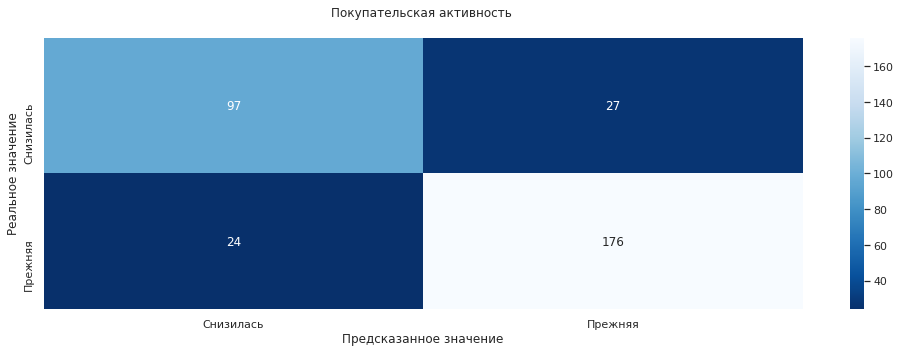

In [41]:
c_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (17, 5))
sns.heatmap(c_matrix, annot = True, fmt = 'd', cmap = 'Blues_r')
plt.xlabel('Предсказанное значение')
plt.ylabel('Реальное значение')
plt.title('Покупательская активность \n')
plt.xticks([0.5, 1.5], ['Снизилась', 'Прежняя']) 
plt.yticks([0.5, 1.5], ['Снизилась', 'Прежняя'])
plt.show()

Наша модель хорошо справляется с прогнозированием классов на тестовых данных. Однако нас интересует более точное прогнозирование вероятности снижения покупательской активности в будущем. Поэтому мы можем пожертвовать точностью прогнозирования значений True Positive. Построим графики Precision и Recall, и найдем оптимальное пороговое значение для классификации нашей модели.

<div class="alert alert-info"> <b>Комментарий студента:</b>

Задача по удержанию, так что важнее первое. Цель не найти новых, не сэкономить средств на продвижении, а сохранить/нарастить количество постоянной лояной аудитории. Комания даже обратилась за более глубоким мнением и тратит на это мнение средства, и в маркетинг она вкладываться готова.

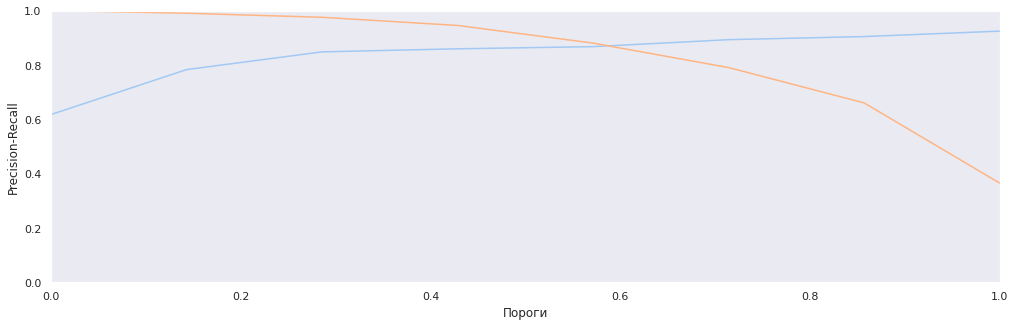

Оптимальное значение порога для модели: 0.57143


In [42]:
y_proba = model.predict_proba(X_test_model)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize = (17, 5))
plt.plot(thresholds, precision[:-1])
plt.xlabel('Пороги')
plt.ylabel('Precision-Recall')
plt.plot(thresholds, recall[:-1])
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(
    f'Оптимальное значение порога для модели: '
    f'{round(thresholds[np.argmin(abs(precision - recall))], 5)}')

Подставим полученное нами оптимальное значение порога и построим новую матрицу ошибок.   

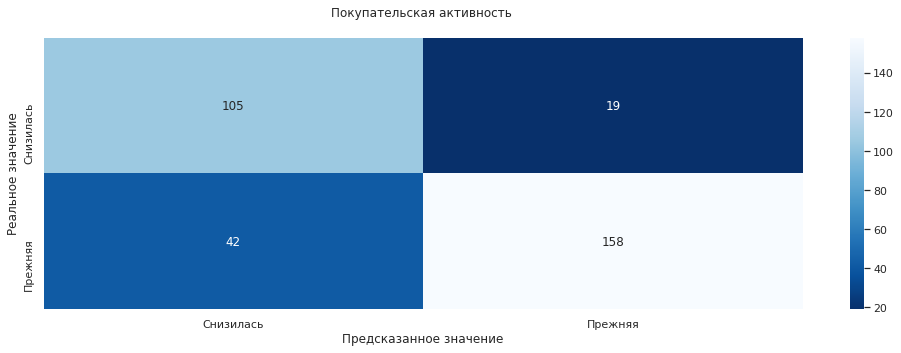

In [43]:
y_proba_threshold = (y_proba > 0.57143).astype(int)

c_matrix_2 = confusion_matrix(y_test, y_proba_threshold)
plt.figure(figsize = (17, 5))
sns.heatmap(c_matrix_2, annot = True, fmt = 'd', cmap = 'Blues_r')
plt.xlabel('Предсказанное значение')
plt.ylabel('Реальное значение')
plt.title('Покупательская активность \n')
plt.xticks([0.5, 1.5], ['Снизилась', 'Прежняя']) 
plt.yticks([0.5, 1.5], ['Снизилась', 'Прежняя'])
plt.show()

In [44]:
print('FP (или ошибка 1го рода) ==', 158/(158+19))

FP (или ошибка 1го рода) == 0.8926553672316384


С такими настройками порога классификации модель способна точно предсказывать снижение активности в тестовой выборке в 105 случаях из 124 ~ 84,7%, упуская 19 случаев снижения покупательской активности. Таким образом, ошибка первого рода будет возникать в ~ 15,3% случаев. С другой стороны ошибка второго рода будет возникать в 21% случаев, и для бизнеса вероятнее всего выгоднее недопустить снижение активности клиентов, чем разослать лишние промокоды или специальные предложения тем, чья активность и так бы не снизилась.

Поскольку лучшей моделью по результатам конвейера была признана модель `kNN`, мы не сможем объяснить признаки непосредственно из этой модели. При использовании библиотеки `SHAP` мы не сможем использовать `LinearExplainer`, и нам придется обратиться к `KernelExplainer`. Однако обработка нашего датасета займет много времени. Мы можем взглянуть только на сэмпл данных, но даже обработка 20 сэмплов займет несколько минут.

<div class="alert alert-info"> <b>Комментарий студента:</b>

 Что-то, да. нето. Переписал.
    
 Зато по такими аномалиям в проекте можно определять состояние, в каком оно писалось)

In [45]:
explainer = shap.KernelExplainer(model.predict, X_train_model.sample(100))

shap_values = explainer(X_train_model.sample(20))

  0%|          | 0/20 [00:00<?, ?it/s]

Взглянем на графики для нашего сэмпла.

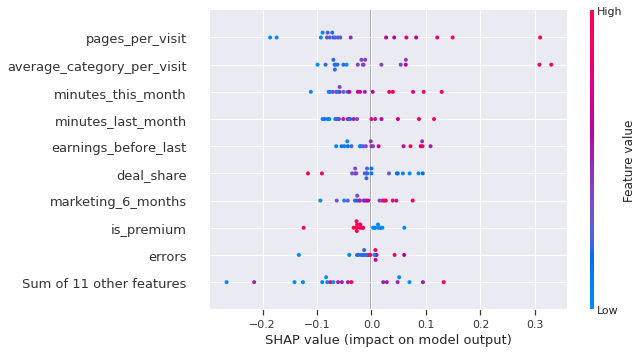

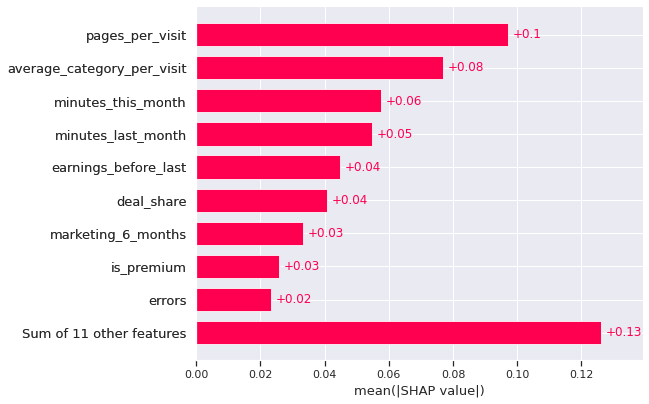

In [46]:
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

В соответствии с полученными графиками нельзя сказать, что какие-то признаки выделяются особой значимостью. Наиболее значимые признаки — это первые 6 признаков. Однако важно отметить, что значимость признаков может меняться от образца к образцу. Если посмотреть на графики, то можно увидеть, что они могут сильно отличаться от образца к образцу.

Если посмотреть на матрицу корреляции с тепловой картой, которую мы собирали ранее, то увидим, что коэффициент корреляции между целевым признаком и указанными признаками дает примерно такую же картину.

По итогам анализа можно сделать вывод, что важнейшим показателем, влияющим на покупательскую активность и находящимся под контролем интернет-магазина, является объем маркетинговых кампаний за последние полгода. Важно также количество приобретенных клиентом товаров по акциям. Можно предположить, что увеличение числа скидок для клиентов, что положительно скажется на числе приобретенных товаров, также положительно скажется на сохранении их текущего уровня покупательской активности.


# Сегментация покупателей

Добавим в наш датафрейм данные из датафрейма `money`.

In [47]:
extra = df.merge(money, on = 'id')

extra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          1296 non-null   int64  
 1   same_level_activity         1296 non-null   bool   
 2   is_premium                  1296 non-null   bool   
 3   allow_marketing             1296 non-null   bool   
 4   marketing_6_months          1296 non-null   float64
 5   marketing_this_month        1296 non-null   int64  
 6   days_since_registration     1296 non-null   int64  
 7   deal_share                  1296 non-null   float64
 8   popular_category            1296 non-null   object 
 9   average_category_per_visit  1296 non-null   int64  
 10  unpaid_goods_quarter        1296 non-null   int64  
 11  errors                      1296 non-null   int64  
 12  pages_per_visit             1296 non-null   int64  
 13  earnings_this_month         1296 

Изучим сегмент покупателей, приобретающих товары для детей. Как мы видим, это не те покупатели, которые приобретают товары для себя. Зачастую они покупают товары в подарок своим детям. Это позволяет нам лучше понять, как выглядят покупатели данной категории товаров.

In [48]:
segment = extra[extra['popular_category'] == 'товары для детей'].drop('popular_category', axis = 1)
segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 0 to 1287
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          329 non-null    int64  
 1   same_level_activity         329 non-null    bool   
 2   is_premium                  329 non-null    bool   
 3   allow_marketing             329 non-null    bool   
 4   marketing_6_months          329 non-null    float64
 5   marketing_this_month        329 non-null    int64  
 6   days_since_registration     329 non-null    int64  
 7   deal_share                  329 non-null    float64
 8   average_category_per_visit  329 non-null    int64  
 9   unpaid_goods_quarter        329 non-null    int64  
 10  errors                      329 non-null    int64  
 11  pages_per_visit             329 non-null    int64  
 12  earnings_this_month         329 non-null    float64
 13  earnings_last_month         329 no

Добавим в датафрейм новый столбец, который будет отражать изменение выручки. Если выручка снижается от месяца к месяцу, то мы поставим значение `decreased`. Если выручка увеличивается, то `increased`. В остальных случаях мы поставим значение `same`.

In [49]:
for index, row in segment.iterrows():
    if (row['earnings_last_month'] < row['earnings_before_last']
        and row['earnings_this_month'] < row['earnings_last_month']):
        segment.at[index, 'earnings'] = 'decreased'
    elif (row['earnings_last_month'] > row['earnings_before_last']
          and row['earnings_this_month'] > row['earnings_last_month']):
        segment.at[index, 'earnings'] = 'increased'
    else:
        segment.at[index, 'earnings'] = 'same'

Теперь добавим информацию о количестве ошибок, с которыми столкнулись пользователи сервиса. Если это количество превышает среднее или медианное значение ~4, то мы предполагаем, что пользователь испытал больше негативных эмоций, чем позитивных, при использовании сайта.

In [50]:
for index, row in segment.iterrows():
    if row['errors'] > 4:
        segment.at[index, 'website_experience'] = 'negative'
    else:       
        segment.at[index, 'website_experience'] = 'positive'

Теперь  посмотрим, как изменились маркетинговые коммуникации с пользователями. Стало ли их меньше `decreased`, больше `increased` или их количество осталось таким же `same`, как и по сравнению с предыдущим полугодием.

In [51]:
for index, row in segment.iterrows():
    if row['marketing_6_months'] > row['marketing_this_month']:
        segment.at[index, 'marketing'] = 'decreased'
    elif row['marketing_6_months'] <  row['marketing_this_month']:
        segment.at[index, 'marketing'] = 'increased'
    else:
        segment.at[index, 'marketing'] = 'same'

Выделим пользователей, от которых снизилась выручка, уменьшилось количество маркетинговых коммуникаций, и которые столкнулись с большим количеством ошибок при использовании сайта.

In [52]:
segment[(segment['earnings'] == 'decreased' )
           & (segment['marketing'] == 'decreased')
           & (segment['website_experience'] == 'negative')]

,id,same_level_activity,is_premium,allow_marketing,marketing_6_months,marketing_this_month,days_since_registration,deal_share,average_category_per_visit,unpaid_goods_quarter,errors,pages_per_visit,earnings_this_month,earnings_last_month,earnings_before_last,minutes_this_month,minutes_last_month,earnings_per_quarter,earnings,website_experience,marketing
323,215675,False,False,True,5.500,5,726,0.160,4,5,7,5,"5,128.400","5,150.500","5,326.000",14,13,4.310,decreased,negative,decreased
329,215681,False,False,False,4.800,3,788,0.210,2,3,7,16,"4,079.200","4,477.000","5,086.000",19,15,4.790,decreased,negative,decreased


Таких пользователей оказалось всего 2 из 329. Возможно, опыт использования сайта не имеет такого большого значения, как мы предполагали изначально. Рассмотрим без учета этого фактора.

In [53]:
segment[(segment['earnings'] == 'decreased' )
           & (segment['marketing'] == 'decreased')]

,id,same_level_activity,is_premium,allow_marketing,marketing_6_months,marketing_this_month,days_since_registration,deal_share,average_category_per_visit,unpaid_goods_quarter,errors,pages_per_visit,earnings_this_month,earnings_last_month,earnings_before_last,minutes_this_month,minutes_last_month,earnings_per_quarter,earnings,website_experience,marketing
89,215441,False,False,True,4.100,4,922,0.290,6,7,1,5,"4,029.400","4,305.000","4,443.000",12,7,3.600,decreased,positive,decreased
129,215481,False,False,True,3.800,3,844,0.930,3,8,4,2,"3,560.100","3,720.000","4,374.000",11,10,4.420,decreased,positive,decreased
189,215541,False,False,False,4.400,4,616,0.270,1,7,4,2,"3,416.600","3,518.000","4,605.000",9,10,4.480,decreased,positive,decreased
229,215581,False,False,True,4.000,3,171,0.250,3,4,3,5,"4,679.200","4,700.000","4,798.000",12,8,4.340,decreased,positive,decreased
323,215675,False,False,True,5.500,5,726,0.160,4,5,7,5,"5,128.400","5,150.500","5,326.000",14,13,4.310,decreased,negative,decreased
329,215681,False,False,False,4.800,3,788,0.210,2,3,7,16,"4,079.200","4,477.000","5,086.000",19,15,4.790,decreased,negative,decreased
358,215710,False,True,True,3.500,3,658,0.980,3,0,2,5,"3,821.900","4,052.000","4,402.000",14,7,3.590,decreased,positive,decreased
405,215757,True,False,True,4.900,4,998,0.400,3,0,2,8,"4,557.400","4,664.000","4,901.000",18,18,3.270,decreased,positive,decreased
415,215767,True,True,True,4.100,4,316,0.120,2,3,4,6,"4,379.300","4,729.000","5,282.000",18,14,3.830,decreased,positive,decreased
483,215835,False,False,True,3.500,3,370,0.250,2,2,4,9,"4,687.800","4,862.000","5,213.000",14,21,4.780,decreased,positive,decreased


Получился срез из 14 пользователей. У 9 из них покупательская активность уже снизилась, а у 5 она осталась на том же уровне. Рассмотрим их подробнее.



In [54]:
display(segment[(segment['earnings'] == 'decreased' )
           & (segment['marketing'] == 'decreased')
           & (segment['same_level_activity'] == True)].describe())
segment[(segment['earnings'] == 'decreased' )
           & (segment['marketing'] == 'decreased')
           & (segment['same_level_activity'] == True)]

,id,marketing_6_months,marketing_this_month,days_since_registration,deal_share,average_category_per_visit,unpaid_goods_quarter,errors,pages_per_visit,earnings_this_month,earnings_last_month,earnings_before_last,minutes_this_month,minutes_last_month,earnings_per_quarter
count,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000
mean,"216,077.600",4.780,4.200,710.400,0.212,3.400,2.400,2.800,10.400,"4,458.040","4,691.000","5,102.400",18.200,16.000,3.478
std,323.965,0.545,0.447,289.220,0.125,0.894,1.817,1.304,3.362,380.644,180.223,165.603,1.483,2.550,0.347
min,"215,757.000",4.100,4.000,316.000,0.110,2.000,0.000,1.000,6.000,"3,891.000","4,450.000","4,901.000",16.000,13.000,3.120
25%,"215,767.000",4.400,4.000,600.000,0.120,3.000,1.000,2.000,8.000,"4,379.300","4,659.000","4,974.000",18.000,14.000,3.270
50%,"216,142.000",4.900,4.000,645.000,0.150,4.000,3.000,3.000,11.000,"4,516.000","4,664.000","5,110.000",18.000,16.000,3.300
75%,"216,194.000",5.000,4.000,993.000,0.280,4.000,4.000,4.000,13.000,"4,557.400","4,729.000","5,245.000",19.000,18.000,3.830
max,"216,528.000",5.500,5.000,998.000,0.400,4.000,4.000,4.000,14.000,"4,946.500","4,953.000","5,282.000",20.000,19.000,3.870


,id,same_level_activity,is_premium,allow_marketing,marketing_6_months,marketing_this_month,days_since_registration,deal_share,average_category_per_visit,unpaid_goods_quarter,errors,pages_per_visit,earnings_this_month,earnings_last_month,earnings_before_last,minutes_this_month,minutes_last_month,earnings_per_quarter,earnings,website_experience,marketing
405,215757,True,False,True,4.900,4,998,0.400,3,0,2,8,"4,557.400","4,664.000","4,901.000",18,18,3.270,decreased,positive,decreased
415,215767,True,True,True,4.100,4,316,0.120,2,3,4,6,"4,379.300","4,729.000","5,282.000",18,14,3.830,decreased,positive,decreased
790,216142,True,False,False,5.500,5,645,0.280,4,4,3,14,"4,516.000","4,659.000","4,974.000",16,13,3.300,decreased,positive,decreased
842,216194,True,False,True,5.000,4,600,0.150,4,4,1,11,"4,946.500","4,953.000","5,110.000",20,16,3.870,decreased,positive,decreased
1176,216528,True,True,True,4.400,4,993,0.110,4,1,4,13,"3,891.000","4,450.000","5,245.000",19,19,3.120,decreased,positive,decreased


В данной группе есть 2 пользователя с премиум подписками и 4 с разрешениями на дополнительные маркетинговые сообщения по интересующим товарам. Эти пользователи в среднем зарегистрировались на сайте свыше двух лет назад. Пользователи без подписок совершают больше акционных покупок (от 15% до 40%). Время, проведенное на сайте (в минутах), остается стабильным или даже увеличивается в некоторых случаях, а опыт использования сайта можно назвать “позитивным” (меньше ошибок, чем в среднем).

Несмотря на то что пользователи в среднем просматривают 10-11 страниц за сессию, количество их покупок уменьшается, а количество непроданных товаров в корзине минимально (в среднем меньше 3, медианное значение – 3). Вероятно, стоит ввести новый уровень подписки на сервис – между бесплатной и премиум, который бы стимулировал пользователей совершать больше покупок и приносить больший доход магазину.

Также стоит рассмотреть возможность внедрения программы лояльности, которая позволила бы пользователям копить бонусы и тратить их на покупки в магазине, стимулируя их совершать покупки в тех случаях, когда они не уверены в необходимости сделать это прямо сейчас. Мы работаем с устоявшейся аудиторией сайта, и наша цель – сохранить это ядро, которое продолжает приносить прибыль. Новым клиентам сложнее прийти, чем сохранить старых. Т.к. целевая аудитория практически полностью освоена.

Обязательно нужно организовать акции, связанные днем рождения детей, а также возможно предложить дополнительную скидку на покупки для матери в этот период, что может положительно сказаться на общей сумме покупки. Для некоторых товаров детской категории можно предложить скидку, зависящую от количества. Например, при покупке определенного количества упаковок с салфетками, подгузниками или детским питанием, следующая покупка должна быть со скидкой.

Активность пользователей, которые совершают покупки преимущественно в разделе “Товары для детей”, сильно зависит от того, как часто на сайте проводятся различные акции (розыгрыши призов, распродажи). Чтобы удержать эту аудиторию, мы предлагаем рассмотреть возможность создания промежуточной ступени подписки между бесплатной версией и премиум-версией, внедрение программы лояльности для постоянных пользователей, предоставление дополнительных скидок, привязанных к датам или скидок, связанных с покупкой определенного количества одного и того же товара.

<div class="alert alert-info"> <b>Комментарий студента:</b>

Согласен с тем, что анализ можно углубить и расширить, рассмотреть вообще всех пользователей под разными углами и с разных точек зрения, графики по каждому этапу строить и т.д. пострался выдержать грань разумного. Без фанатизма, но и принализировать при этом, чтобы выдать результат.

# Итоговые выводы

Мы загрузили необходимые модули и библиотеки для работы, провели первоначальный анализ первых строк четырех таблиц. Были обнаружены опечатки в некоторых колонках. Судя по количеству записей в таблицах, сервис предоставил информацию о 1300 клиентах и об их покупательской активности на сайте в течение трех месяцев. Интересно отметить, что в трех колонках первой таблицы содержатся данные за шесть месяцев, а во всех четырех таблицах есть столбец `id`, который позволяет установить однозначную связь между клиентом и информацией о нем, собранной в разных таблицах.

Мы выполнили переименование столбцов в четырёх датафреймах, изменение регистра одного столбца в датафрейме `mfile` и преобразование типов данных четырёх столбцов в двух датафреймах к типу булевых значений. В процессе работы мы обнаружили отсутствие полных дубликатов в данных, а также то, что каждый из датафреймов содержит информацию о 1300 уникальных номерах покупателей из базы данных. Мы допустили, что эти 1300 номеров присутствуют во всех четырёх датафреймах, так как в целом данные отличаются хорошим качеством подготовки.

Мы изучили данные во всех колонках всех четырех дата-фреймов и провели статистический анализ распределения данных. Удалены 1 аномалия и 3 записи о клиентах, не совершавших покупки в течение двух месяцев. Средний покупатель интернет-магазина “В один клик” сохранил прежний уровень покупательской активности, не имеет премиум-подписки на сервис, разрешил дополнительные маркетинговые рассылки по интересующим его товарам. Он приобретал товары в категориях “Товары для детей”, “Домашний текстиль” или “Косметика и аксессуары”, имел в среднем чуть более 4 маркетинговых рассылок (4 рассылки в текущем месяце), зарегистрировался на сайте около 600 дней назад, около 24% товаров приобрел по акции. В текущем месяце он просмотрел 3 категории товаров за визит на сайт, имеет около 3 непроданных товаров в корзине за квартал, и столкнулся с примерно 4 сбоями во время посещения сайта, просмотрев около 8 страниц.

В результате проведенных манипуляций с данными нам удалось объединить три исходных дата-фрейма в один. Корреляционный анализ выявил довольно слабую связь между целевым признаком и предикторами. По итогам работы пайплайна с данными после устранения дисбаланса классов, лучшей метрикой Accuracy на тренировочных (0,88) и тестовых (0,84) данных показала модель kNN с использованием манхэттенской дистанции для 7 ближайших соседей и стандартным масштабированием числовых признаков.

По результатам проведенного анализа можно сделать вывод, что самым важным показателем, влияющим на покупательскую активность и управляемым интернет-магазином, является объем маркетинговых коммуникаций за последние полгода. Также важно количество акционных товаров, приобретенных клиентом. Можно предположить, что увеличение количества предоставляемых скидок клиентам положительно скажется на количестве приобретаемых товаров и на сохранении их текущего уровня покупательской активности.

По результатам анализа сегмента пользователей, которые совершают покупки в основном в разделе “Товары для детей”, мы определили, что их покупательская активность сильно зависит от проведения различных акций на сайте (розыгрышей призов, распродаж). Для удержания такой аудитории мы предлагаем создать промежуточный уровень подписки между бесплатным и премиум тарифами, внедрить программу лояльности для постоянных клиентов, предлагать дополнительные скидки на определенные даты или скидки за покупку определенного количества одинаковых товаров.

<div class="alert alert-info"> <b>Комментарий студента:</b>

Александр, спасибо тебе проверку и дробрые слова! 
    
За информативные коментарии и замечания даже тамм, где все ок и комментарий "зеленый". Однозначно уже на этом этапе узнал что-то новое и полезное для себя. За  статьи отдельное спасибо, и очень жду по визуализации почитать что, а то не очень комфортный для меня этот фронт работ, чуссвтую ,что не хвает мне там увренности и знаний.